# 1. SETTINGS

In [2]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.metrics import log_loss
from sklearn.neighbors import NearestNeighbors
import copy
import scipy.stats
import os
import time

/Users/nikita.kozodoi/anaconda3/envs/py3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
# pandas options
pd.set_option('display.max_columns', None)

In [4]:
# dark background style
plt.style.use('dark_background')

In [5]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# garbage collection
import gc
gc.enable()

In [7]:
# helper functions
import functions
from functions import *

# 2. DATA PREPARATION

In [8]:
# import CSV
df = pd.read_csv('../data/data_v2.csv')
print(df.shape)

(11840, 96)


In [9]:
# target variable
target = 'duration'

In [10]:
# partitioning
train = df[df[target].isnull() == False]
test  = df[df[target].isnull() == True]
print(train.shape)
print(test.shape)

(8880, 96)
(2960, 96)


In [11]:
# target variable
y = train[target]
del train[target], test[target]
classes = y.unique()
classes

array([2., 1., 0.])

# 3. MODELING

### PARAMETERS

In [12]:
# drop bad features
excluded_feats = ['id', 'image_url', 'product_description']
features = [f for f in train.columns if f not in excluded_feats]
print(train[features].shape)

(8880, 93)


In [13]:
### PARAMETERS

# settings
cores = -1
seed  = 2

# cross-validation
num_folds = 5
shuffle   = True

# muner of rounds
max_rounds = 1000
stopping   = 200
verbose    = 200

# LGB parameters
lgb_params = {
    'boosting_type':     'gbdt',
    'objective':         'multiclass',
    'metric':            'multi_logloss',
    'num_class':         len(classes),
    'bagging_fraction':  0.9,
    'feature_fraction':  0.9,
    'lambda_l1':         0.1,
    'lambda_l2':         0.1,
    'min_split_gain':    0,
    'min_child_weight':  0.1,
    'min_child_samples': 20,
    'silent':            True,
    'verbosity':         -1,
    'learning_rate':     0.03,
    'max_depth':         5,
    'num_leaves':        50,
    'scale_pos_weight':  1,
    'n_estimators':      max_rounds,
    'nthread' :          cores,
    'random_state':      seed,
}

# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

In [14]:
# placeholders
clfs = []
valid_perf  = np.zeros(num_folds) 
importances = pd.DataFrame()

#preds_test   = np.zeros(test.shape[0])
#preds_oof    = np.zeros(train.shape[0])

preds_oof  = np.zeros((len(train), len(classes)))
preds_test = np.zeros((len(test),  len(classes)))

In [15]:
# SMOTE settings
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state = 23, n_jobs = 10, sampling_strategy = 0.1)

### CROSS-VALIDATION

In [16]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    test_x       = test[features]
    
    ## remove outliers
    #out_idx = (np.abs(scipy.stats.zscore(trn_x)) < 10).all(axis = 1)
    #trn_x = trn_x[out_idx]
    #trn_y = trn_y[out_idx]
    
    # scale data
    #scaler   = RobustScaler()
    #trn_x    = pd.DataFrame(scaler.fit_transform(trn_x), columns = features)
    #val_x    = pd.DataFrame(scaler.transform(val_x),     columns = features)
    #tmp_test = pd.DataFrame(scaler.transform(test_x),    columns = features)

    # augment training data with SMOTE
    #trn_x, trn_y = sm.fit_sample(trn_x, trn_y)
    #trn_x = pd.DataFrame(trn_x, columns = features)
    #trn_y = pd.Series(trn_y)
       
    # add noise to train to reduce overfitting
    #trn_x += np.random.normal(0, 0.01, trn_x.shape)
    
    # mean target encoding
    #trn_x, val_x, test_x = mean_target_encoding(trn_x, val_x, test, features = ['trustLevel'], target = 'fraud', folds = 5)
    #features = [f for f in trn_x.columns if f not in excluded_feats]
        
    # train lightGBM
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  early_stopping_rounds = stopping,
                  verbose               = verbose)
    clfs.append(clf)
    
    # find the best iteration
    best_iter = clf.best_iteration_
       
    
############ PERFORM 1 ITERATRION OF SELF-TRAINING
#
#    # predict unlabeled data
#    tmp_preds_test = clf.predict_proba(tmp_test, num_iteration = best_iter)[:, 1]
#
#    # extract most confident preds
#    perc_ones  = 0.0001
#    perc_zeros = 0.0001
#    pmax = np.quantile(tmp_preds_test, 1 - perc_ones)
#    pmin = np.quantile(tmp_preds_test, perc_zeros)
#    tmp_preds_test[tmp_preds_test >= pmax] = 1
#    tmp_preds_test[tmp_preds_test <= pmin] = 0
#    confident_ones  = np.where(tmp_preds_test == 1)
#    confident_zeros = np.where(tmp_preds_test == 0)
#    confident_ones  = confident_ones[0][0:np.round(len(tmp_test)  * perc_ones).astype('int')]
#    confident_zeros = confident_zeros[0][0:np.round(len(tmp_test) * perc_zeros).astype('int')]
#    confident_idx   = np.concatenate((confident_ones, confident_zeros))
#
#    # append new data to train
#    test_X = tmp_test.iloc[confident_idx]
#    test_y = pd.Series(tmp_preds_test[confident_idx])
#    trn_x  = trn_x.append(test_X)
#    trn_y  = trn_y.append(test_y)
#    print('--------------------------------')
#    print('Added %.0f cases to training data...' % len(test_y))
#    print('--------------------------------')
#
#    # retrain lightGBM
#    print('Custom early stopping: select the best out of %.0f iterations...' % max_rounds)
#    clf = lgb.LGBMClassifier(**lgb_params) 
#    clf = clf.fit(trn_x, trn_y, 
#                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
#                  eval_metric           = prediction_reward, 
#                  verbose               = verbose)
#
#    # find the best iteration
#    best_iter = np.argmax(clf.evals_result_['valid_1']['profit']) + 1
#    print('Best iteration is:')
#    print('[' + str(best_iter) + ']   valid_1 profit: ' + 
#          str(prediction_reward(val_y, clf.predict_proba(val_x, num_iteration = best_iter)[:, 1])[1].astype('int')) + 
#          "; log_loss = ", str(np.round(log_loss(val_y, clf.predict_proba(val_x, num_iteration = best_iter)[:, 1]), 6)))
#    
############ PERFORM 1 ITERATRION OF SELF-TRAINING


    # save predictions
    #preds_oof[val_idx]    = clf.predict_proba(val_x,  num_iteration = best_iter)[:, 1]
    #valid_profit[n_fold]  = log_loss(y, preds_oof)
    #preds_test           += clf.predict_proba(test_x, num_iteration = best_iter)[:, 1] / folds.n_splits 
    
    # save predictions
    preds_oof[val_idx, :] = clf.predict_proba(val_x, num_iteration = best_iter)
    valid_perf[n_fold]    = log_loss(y[val_idx], preds_oof[val_idx, :])
    preds_test           += clf.predict_proba(test_x, num_iteration = best_iter) / folds.n_splits 

    # importance
    fold_importance_df               = pd.DataFrame()
    fold_importance_df['Feature']    = features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold']       = n_fold + 1
    importances                      = pd.concat([importances, fold_importance_df], axis = 0)
    
    # print performance
    print('--------------------------------')
    print('FOLD%2d: LOGLOSS = %.6f' % (n_fold + 1, valid_perf[n_fold]))
    print('--------------------------------')
    print('')
        
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    # uncomment for mean target encoding
    #features = [f for f in train.columns if f not in excluded_feats]
    
    
# print overall performance    
cv_perf = np.mean(valid_perf)
print('--------------------------------')
print('MEAN LOGLOSS = %.6f' % cv_perf)
print('--------------------------------')

Training until validation scores don't improve for 200 rounds.
[200]	training's multi_logloss: 0.86315	valid_1's multi_logloss: 0.974566
[400]	training's multi_logloss: 0.783172	valid_1's multi_logloss: 0.964486
[600]	training's multi_logloss: 0.710676	valid_1's multi_logloss: 0.962823
[800]	training's multi_logloss: 0.650466	valid_1's multi_logloss: 0.963777
Early stopping, best iteration is:
[687]	training's multi_logloss: 0.683289	valid_1's multi_logloss: 0.962
--------------------------------
FOLD 1: LOGLOSS = 0.962000
--------------------------------

Training until validation scores don't improve for 200 rounds.
[200]	training's multi_logloss: 0.874656	valid_1's multi_logloss: 0.979345
[400]	training's multi_logloss: 0.790775	valid_1's multi_logloss: 0.966466
[600]	training's multi_logloss: 0.722572	valid_1's multi_logloss: 0.964446
Early stopping, best iteration is:
[547]	training's multi_logloss: 0.738589	valid_1's multi_logloss: 0.963576
--------------------------------
FOLD 2

In [66]:
##### RECHECK PERFORMANCE  
np.round(log_loss(y, preds_oof), 6)


###### TRACKING RESULTS (5 folds, strat = True, seed = 23)

# V1: lgb, 5 folds, default features:  0.966792
# V2: text features (keep = T, k = 5): 0.962709

0.962436

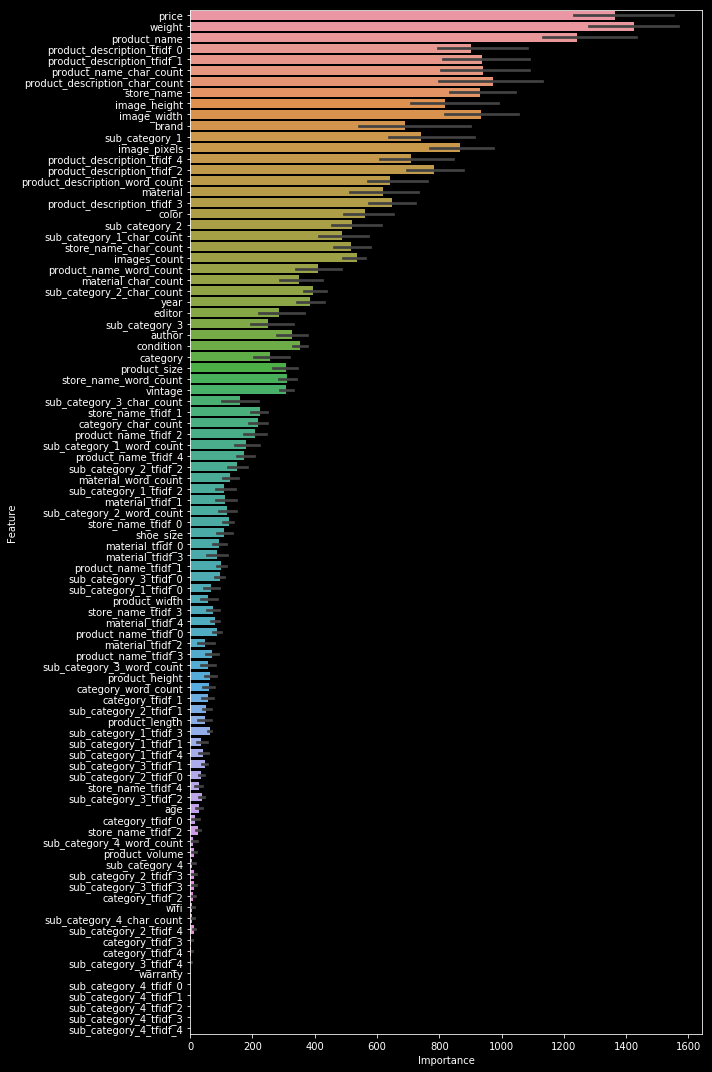

In [67]:
##### VARIABLE IMPORTANCE

# load importance    
top_feats = 100
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 15))
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False))
plt.tight_layout()

# save plot as pdf
plt.savefig('../var_importance.pdf')

# 4. SUBMISSION

In [68]:
# file name
model = 'lgb_v2'
perf  = str(round(cv_perf, 6))[2:7]
name  = model + '_' + perf

In [69]:
# export OOF preds
#oof = pd.DataFrame({'id': train['id'], 'duration': preds_oof})
#oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
#oof.head()

In [70]:
# export submission
#sub = pd.DataFrame({'id': test['id'], 'duration': preds_test})
#sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
#sub.head()

In [71]:
# export OOF preds
oof = pd.DataFrame(preds_oof)
oof.insert(0, column = 'id', value = train['id'].reset_index(drop = True))
oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof.head()

,id,0,1,2
0,0,0.665545,0.206694,0.127761
1,1,0.759495,0.153251,0.087254
2,2,0.565664,0.125828,0.308508
3,3,0.315703,0.315149,0.369148
4,4,0.501933,0.314955,0.183112


In [72]:
# export submission
sub = pd.DataFrame(preds_test)
sub.insert(0, column = 'id', value = test['id'].reset_index(drop = True))
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.head()

,id,0,1,2
0,0,0.234536,0.327510,0.437954
1,1,0.392917,0.251247,0.355835
2,2,0.206695,0.769461,0.023845
3,3,0.207933,0.232336,0.559731
4,4,0.478129,0.280759,0.241112


In [73]:
# check correlation with previous submission
#prev_sub = pd.read_csv('../submissions/lgb_v8_375.csv')
#cor = np.sum(prev_sub[target] == sub.reset_index()[target]) / len(sub)
#print("Share of the same predictions: " + str(np.round(cor, 6)))

In [74]:
# check correlation with previous submission
prev_sub = pd.read_csv('../submissions/lgb_v1_96790.csv')
pd.Series(np.diag(sub.apply(lambda x: prev_sub.corrwith(x))))

FileNotFoundError: [Errno 2] File b'../submissions/lgb_v1_96790.csv' does not exist: b'../submissions/lgb_v1_96790.csv'

In [75]:
# submit to QSCORE
comment = ''
submit_prediction(sub, sep = ',', index = False, comment = str(comment) + ' - ' + name)